In [1]:
# Scientific libraries
import numpy as np
import scipy.stats as stats
import scipy.special as sf
import scipy.integrate as integrate
import scipy.interpolate as interpolate

# import Pandas

import pandas as pd
import astropy.io.fits as fits
import astropy.units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord, CartesianRepresentation, ICRS, GCRS,UnitSphericalRepresentation
# Graphic libraries

import matplotlib.pyplot as plt
%matplotlib notebook
from jupyterthemes import jtplot
plt.style.use('mike_dark') 
jtplot.style(context='notebook', fscale=1, grid=False)

from glob import glob
import copy
import collections
#import warnings
#warnings.simplefilter('ignore')
from pyipn.io.plotting.projection import *
import stan_utility

green = "#1DEBA6"
red = "#FF0059"
yellow = "#F6EF5B"


from pyipn import copy_template, Universe

<IPython.core.display.Javascript object>


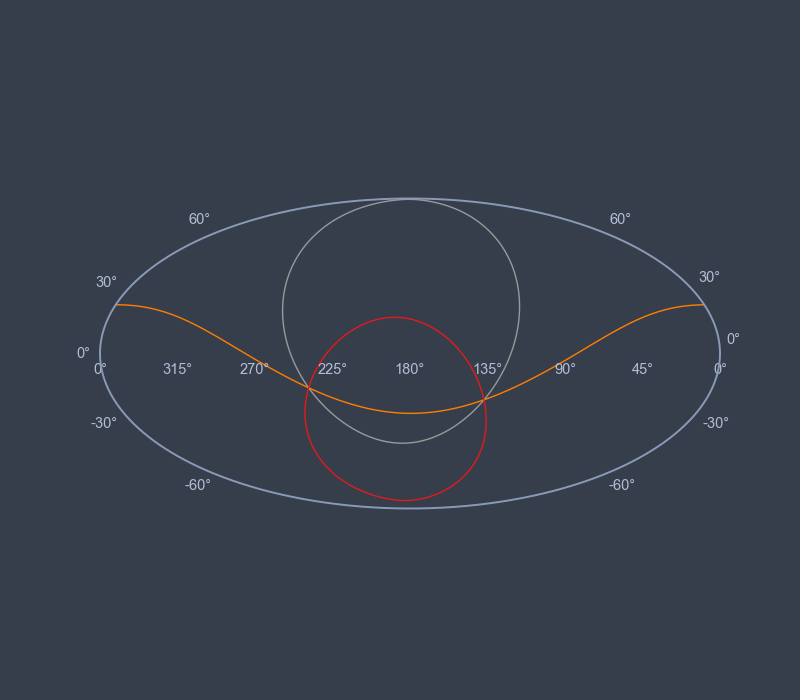

<IPython.core.display.Javascript object>


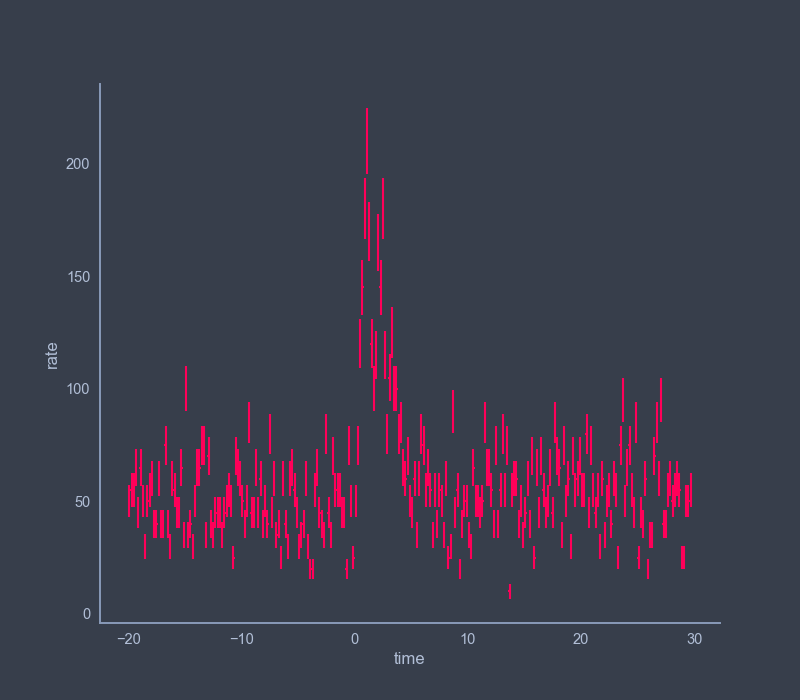

<IPython.core.display.Javascript object>


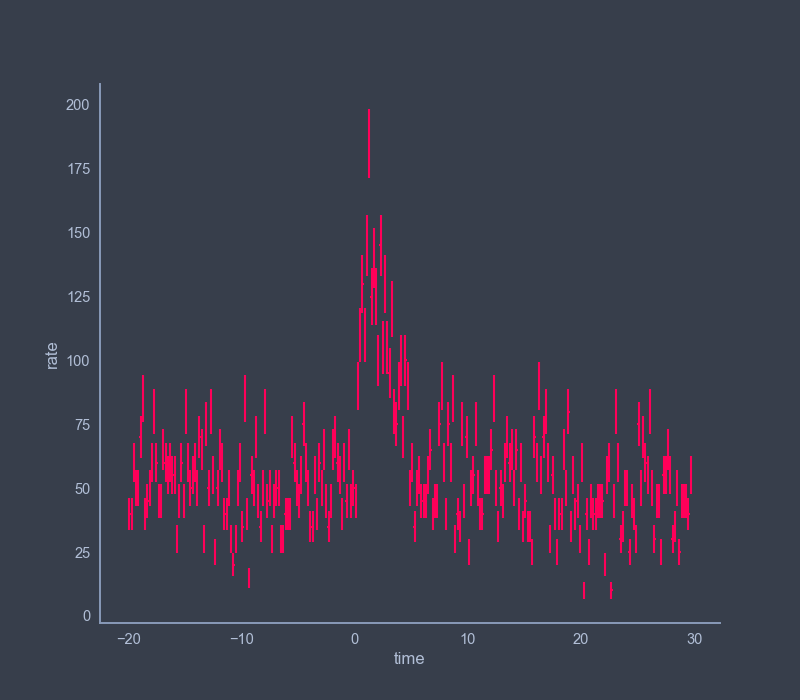

<IPython.core.display.Javascript object>


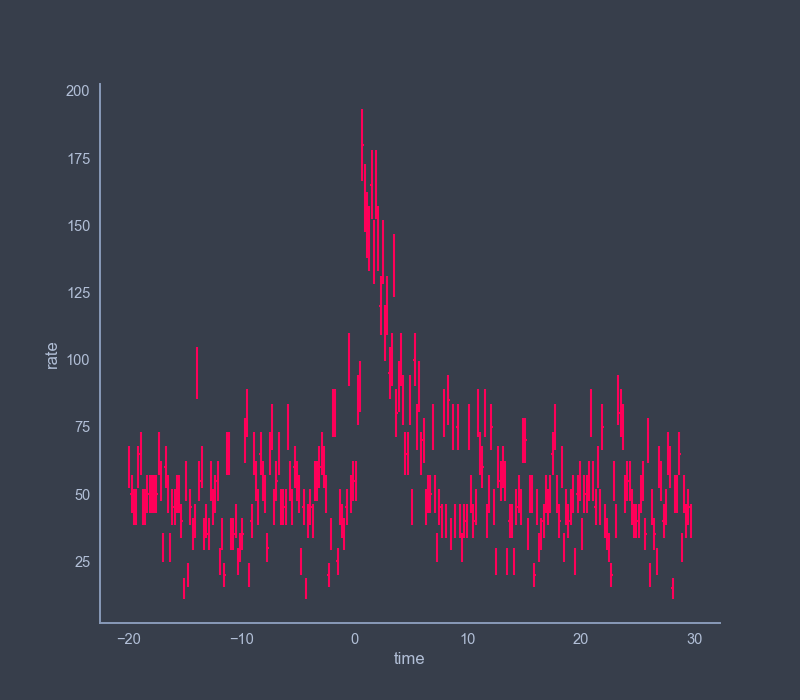

In [83]:

uni = Universe.from_yaml('template_3.yaml')
uni.explode_grb(tstart=-50,tstop=100)
uni.plot_all_annuli(cmap='Set1_r',lw=1);
for det, lc in uni.light_curves.items():

    lc.display(-20,30,.2,color=red)



In [32]:
uni.calculate_annulus('det1','det2')

(<Quantity [-0.92190459, -0.08742345,  0.37742425] km>,
 <Quantity [3.23613909, 0.38701325] rad>,
 <Quantity 3.13419325 rad>)

In [84]:
uni._T0

array([0.05975746, 0.        , 0.06546245])

In [33]:
uni.calculate_annulus('det1','det3')

(<Quantity [-0.43671383,  0.00463391,  0.89958855] km>,
 <Quantity [3.1309822, 1.1188265] rad>,
 <Quantity 2.40385261 rad>)

In [34]:
uni.calculate_annulus('det2','det3')

(<Quantity [0.84035893, 0.1352012 , 0.52489762] km>,
 <Quantity [0.15951811, 0.55259482] rad>,
 <Quantity 0.93912095 rad>)

In [85]:
lc = uni.light_curves['det1']
counts, times = lc.get_binned_light_curve(-20.4,31.4,.25)
mid = np.mean([times[:-1],times[1:]], axis=0)
width = times[1:] - times[:-1]




lc2 = uni.light_curves['det2']

counts2, times2 = lc2.get_binned_light_curve(-20,30,.2)
mid2 = np.mean([times2[:-1],times2[1:]], axis=0)
width2 = times2[1:] - times2[:-1]


lc3 = uni.light_curves['det3']

counts3, times3 = lc3.get_binned_light_curve(-10,20,.1)
mid3 = np.mean([times3[:-1],times3[1:]], axis=0)
width3 = times3[1:] - times3[:-1]

d1 = uni.detectors['det1']
d2 = uni.detectors['det2']
d3 = uni.detectors['det3']

xyz1=d1.location.get_cartesian_coord().xyz.value
xyz2=d2.location.get_cartesian_coord().xyz.value
xyz3=d3.location.get_cartesian_coord().xyz.value


k=25

N_model = 200

predict_time = np.linspace(-20,40,N_model)
omega=np.random.randn(k)

data = dict(N1=len(counts),
            time1=mid,
            counts1=counts.astype(int),
            exposure1=width,
            exposure2=width2,
            N2=len(counts2),
            time2=mid2,
            counts2=counts2.astype(int),
            N3=len(counts3),
            time3=mid3,
            counts3=counts3.astype(int),
            exposure3=width3,
            
            
            k=k,
            bw=.7,
            bw2=.7/2.,
            omega=omega,
            N_model=N_model,
            predict_time=predict_time,
            
            sc_pos1 = xyz1,
            sc_pos2 = xyz2,
             sc_pos3 = xyz3,
           
           
           
           )

In [103]:
model = stan_utility.compile_model('rff_loc3.stan', model_name='rff3')
#model = stan_utility.compile_model('gp_light_curve.stan', model_name='gplc')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL rff3_f5bd650f191aad4fe717347edcbe5467 NOW.


In [87]:
fit = model.sampling(warmup=1500,iter=2000,data=data, chains=4, seed=1234,
                     control = dict(max_treedepth=15, adapt_delta=.9)
                    

                    )

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


<IPython.core.display.Javascript object>


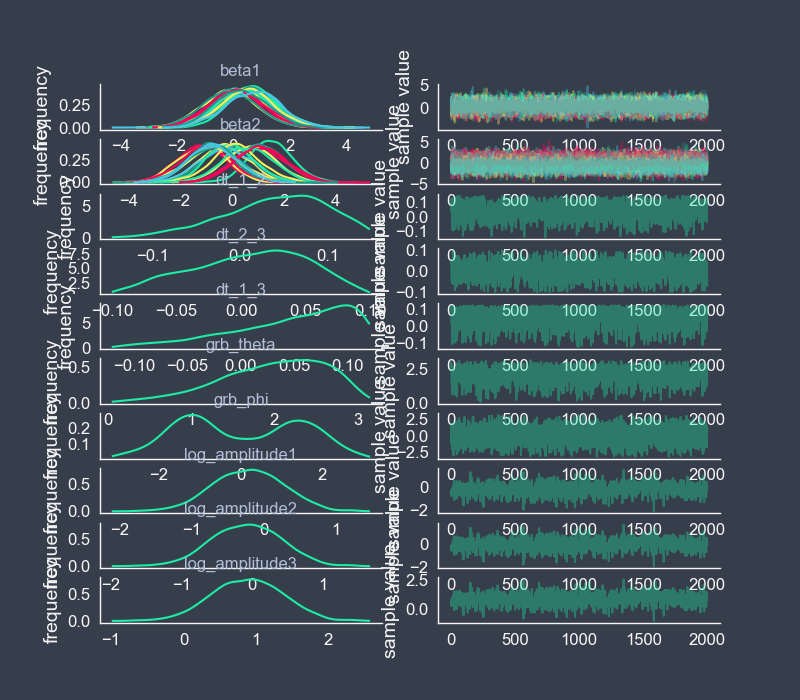

In [88]:
with plt.style.context('mike_dark'):
    fit.plot(['beta1','beta2',
              'dt_1_2',
                'dt_2_3',
                'dt_1_3',
              'grb_theta',
              'grb_phi',
              
              'log_amplitude1',
               'log_amplitude2',
              'log_amplitude3',
            #  'tstart',
         #     'tstop'
             
             ]);

<IPython.core.display.Javascript object>


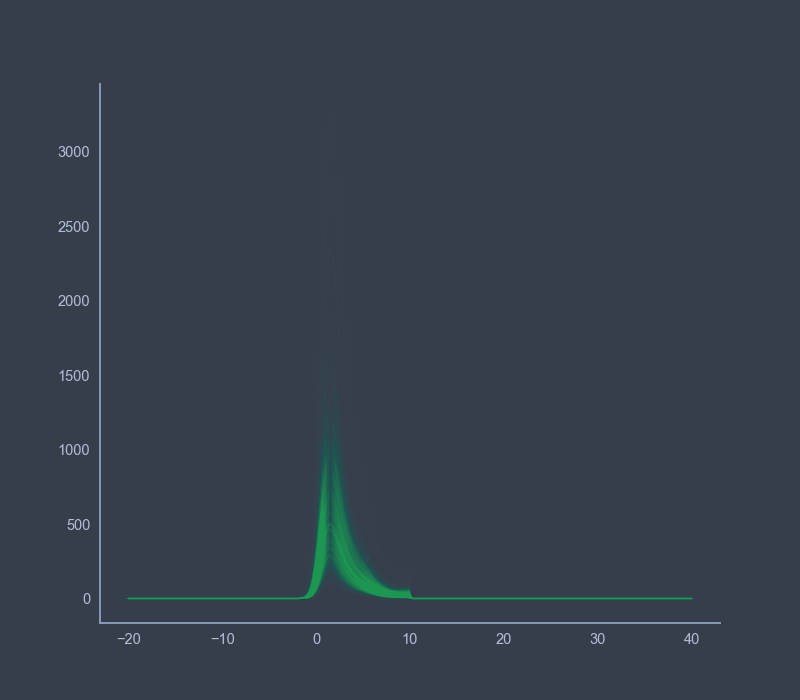

In [89]:
fig, ax = plt.subplots()

predict = fit.extract('predict')['predict']


for p in predict[::2]:

    ax.plot(predict_time,p, alpha=0.01, color=green )


<IPython.core.display.Javascript object>


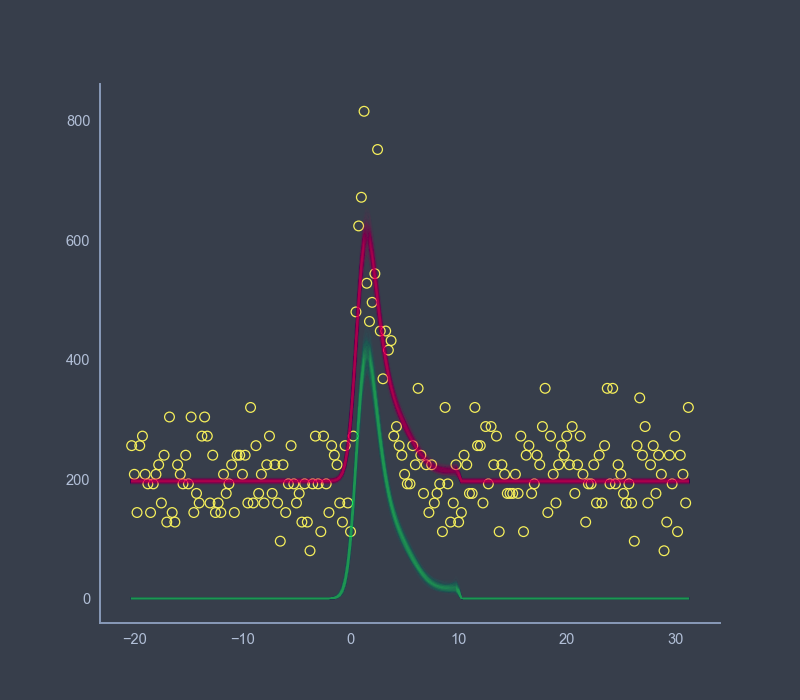

In [90]:
fig, ax = plt.subplots()

fhat = fit.extract("fhat1")["fhat1"]
bkg = fit.extract("bkg1")["bkg1"]

for y, b in zip(fhat[::10], bkg[::10]):

    ax.plot(mid, y, alpha=0.01, color=green)
    ax.plot(mid, (y + b), alpha=0.01, color=red)
#    ax.plot(mid,[b]*len(mid), alpha=0.01, color="k")


ax.scatter(mid, counts/width, edgecolor=yellow, facecolor="none", lw=0.9)

<IPython.core.display.Javascript object>


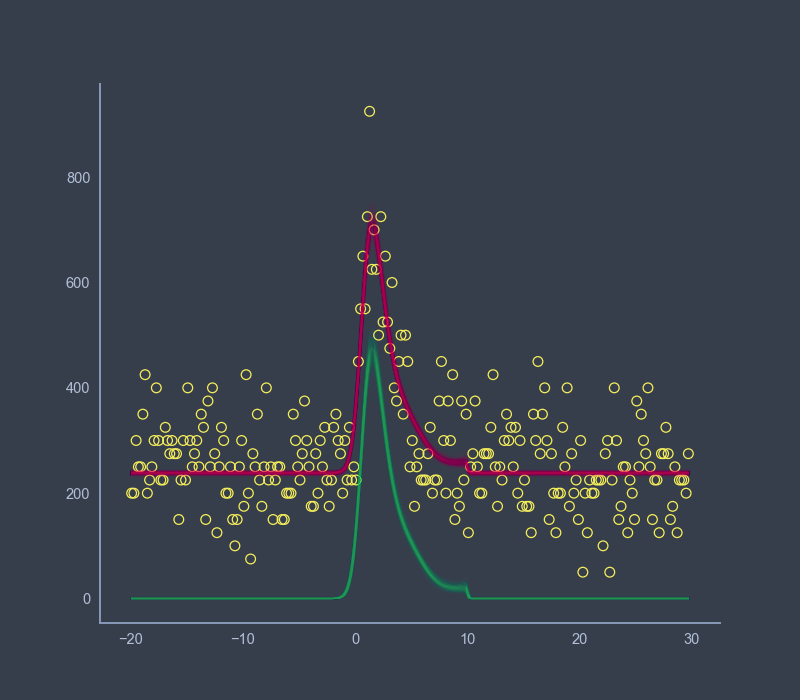

In [91]:
fig, ax = plt.subplots()

fhat = fit.extract('fhat2')['fhat2']
bkg = fit.extract('bkg2')['bkg2']

for y, b in zip(fhat[::10], bkg[::10]):

    ax.plot(mid2,y, alpha=0.01, color=green)
    ax.plot(mid2,y +b, alpha=0.01, color=red)
#    ax.plot(mid2,[b]*len(mid), alpha=0.01, color="k")


ax.scatter(mid2, counts2/width2, edgecolor=yellow, facecolor='none',lw=.9)

<IPython.core.display.Javascript object>


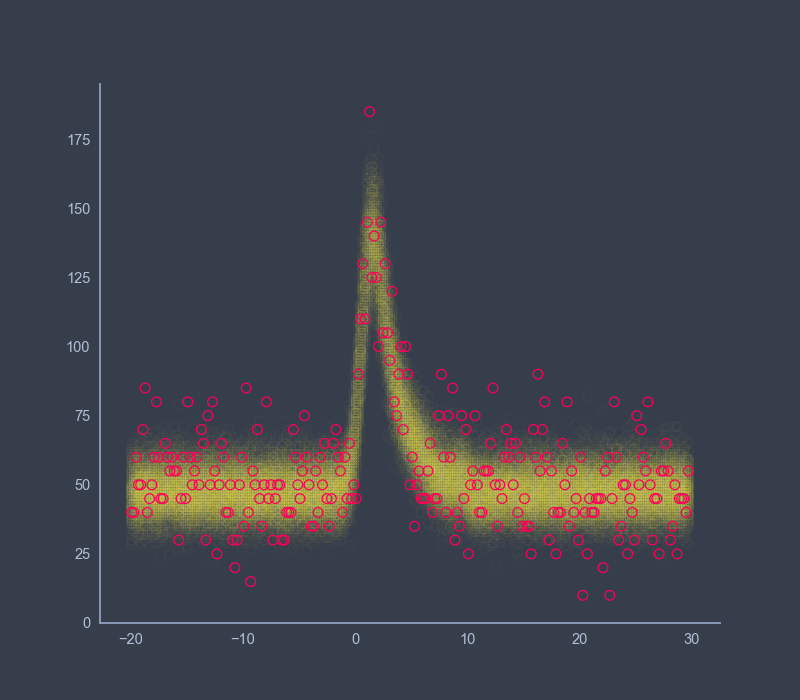

In [92]:
fig, ax = plt.subplots()

ppc2 = fit.extract('ppc2')['ppc2']


for p in ppc2[::10]:

    ax.scatter(mid2,p, alpha=0.025,  edgecolor=yellow, facecolor='none',lw=.9)
   
#    ax.plot(mid2,[b]*len(mid), alpha=0.01, color="k")


ax.scatter(mid2, counts2, edgecolor=red, facecolor='none',lw=.9)

<IPython.core.display.Javascript object>


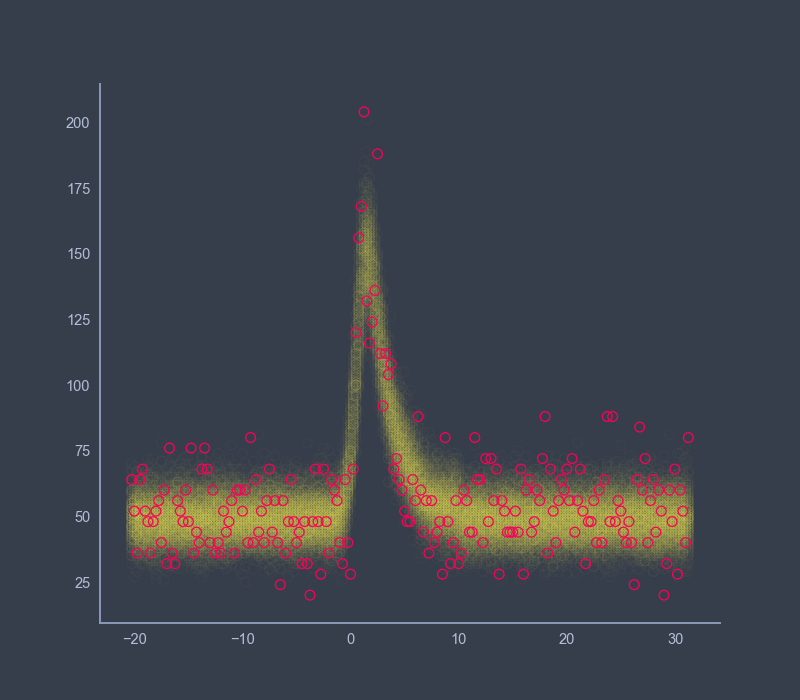

In [93]:
fig, ax = plt.subplots()

ppc1 = fit.extract('ppc1')['ppc1']


for p in ppc1[::10]:

    ax.scatter(mid,p, alpha=0.025,  edgecolor=yellow, facecolor='none',lw=.9)
   
#    ax.plot(mid2,[b]*len(mid), alpha=0.01, color="k")


ax.scatter(mid, counts, edgecolor=red, facecolor='none',lw=.9)

<IPython.core.display.Javascript object>


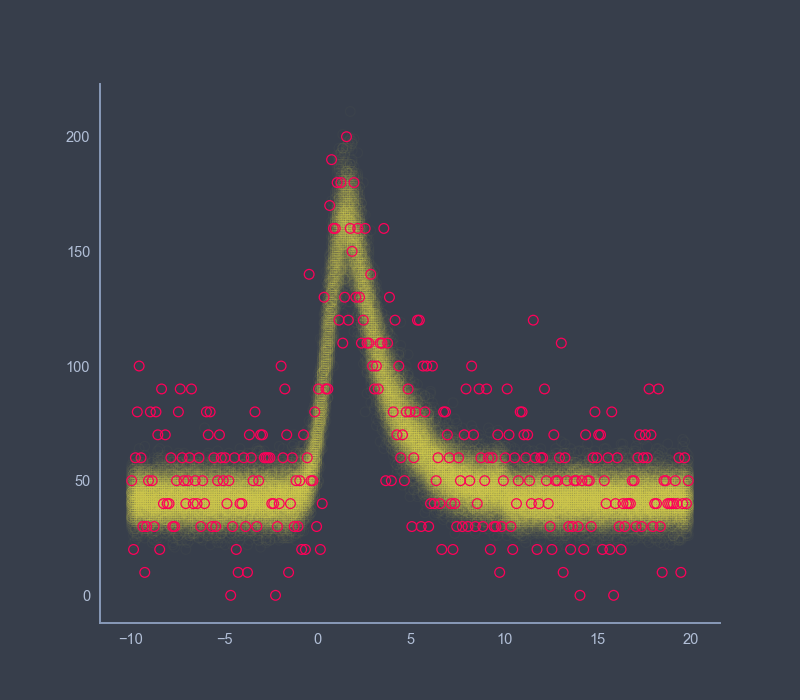

In [94]:
fig, ax = plt.subplots()

ppc3 = fit.extract('ppc3')['ppc3']


for p in ppc3[::10]:

    ax.scatter(mid3,p, alpha=0.025,  edgecolor=yellow, facecolor='none',lw=.9)
   
#    ax.plot(mid2,[b]*len(mid), alpha=0.01, color="k")


ax.scatter(mid3, counts3, edgecolor=red, facecolor='none',lw=.9)

<IPython.core.display.Javascript object>


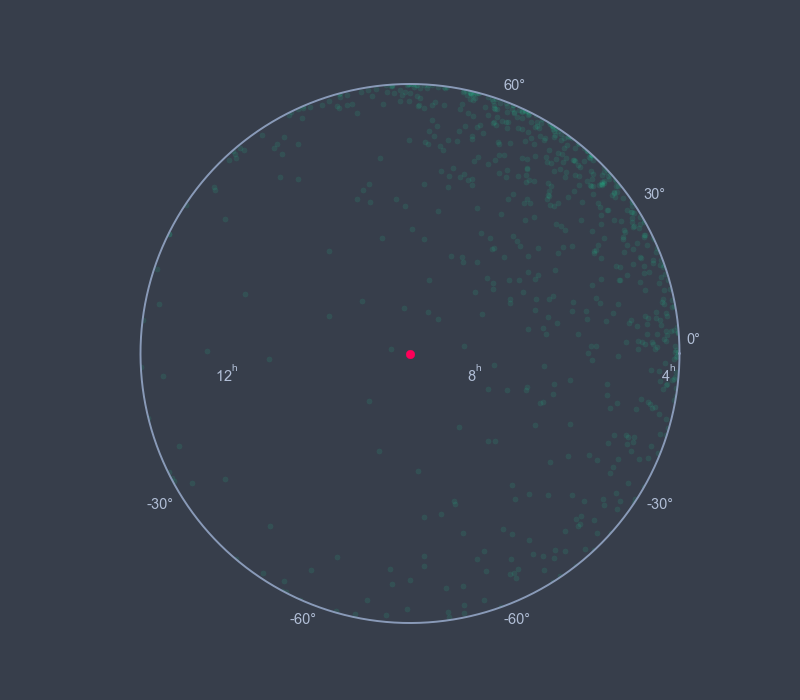

<IPython.core.display.Javascript object>


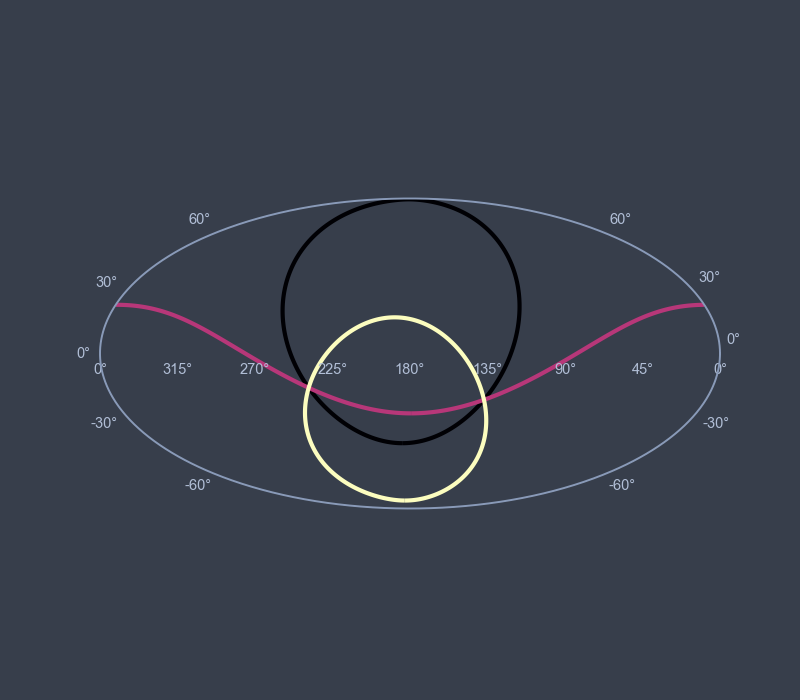

In [98]:
fig, ax = plt.subplots(subplot_kw=dict(projection='astro globe',
                                       center=SkyCoord(135,-22,unit='deg') ))

theta = np.rad2deg(fit.extract('grb_theta')['grb_theta'])
phi = np.rad2deg(fit.extract('grb_phi')['grb_phi'])



idx = phi <= 0

phi[idx] +=360


ax.scatter(phi, theta-90, c=green, alpha=.1,transform=ax.get_transform("icrs"),s=15)
ax.scatter(np.array([135.]),np.array([-22.]),c=red, s=40,transform=ax.get_transform("icrs"))

uni.plot_all_annuli(cmap='magma',lw=3);

In [101]:

from pyipn.geometry import Location
from pyipn.io.plotting.spherical_circle import SphericalCircle
def compute_annulus_from_time_delay(time_delay, detector1, detector2, ax =None ,color=green,**kwargs):
    
    dxyz = (  detector2.location.get_cartesian_coord().xyz - detector1.location.get_cartesian_coord().xyz)
            
    dcart = Location(
    SkyCoord(
        x=dxyz[0],
        y=dxyz[1],
        z=dxyz[2],
        representation_type="cartesian",
        unit="km",
     #   frame='icrs'
    )
        )
    
    
    norm_d = dcart.get_norm_vec(u.km)
    
    distance = np.linalg.norm(dxyz) * u.km
    
    theta = np.arccos(
            np.around(((-const.c * time_delay*u.s ).to('km')/ distance).value, 15)
        )
    
    
    ra = dcart.coord.represent_as(UnitSphericalRepresentation).lon
    dec = dcart.coord.represent_as(UnitSphericalRepresentation).lat
    
    
    if ax is None:
        fig, ax = plt.subplots(subplot_kw=dict(projection='astro degrees mollweide'))
    
    circle = SphericalCircle(
            np.array([ra.value, dec.value]) * ra.unit,
            theta*u.rad,
            vertex_unit=u.deg,
            resolution=5000,
            edgecolor=color,
            facecolor="none",
            transform=ax.get_transform("icrs"),
        **kwargs
       
  
        )
    
    
   
    
    ax.add_patch(circle)
    
    
    
    
    
    
    
    
    
    
    
    
    
    

<IPython.core.display.Javascript object>


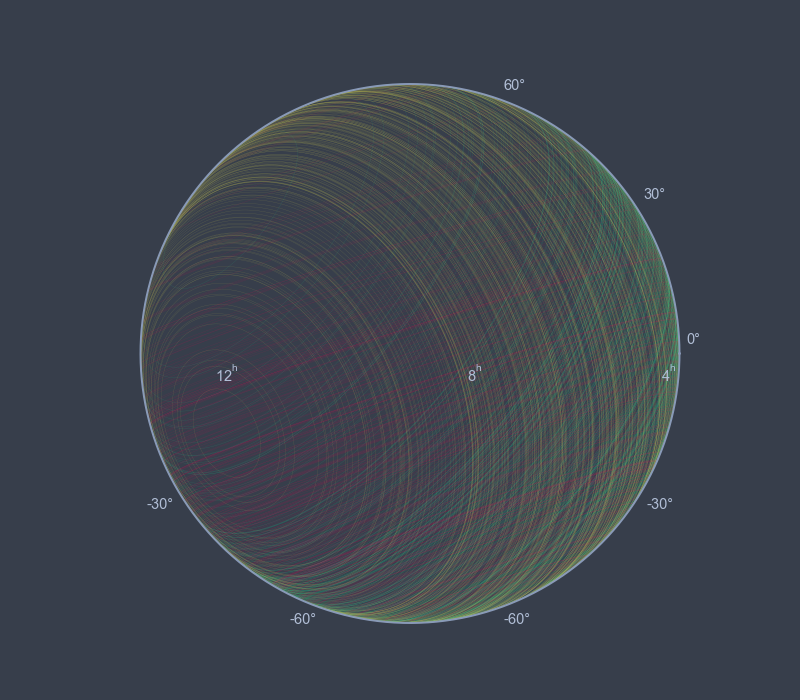

In [102]:

dt = fit.extract('dt_1_2')['dt_1_2']
fig, ax = plt.subplots(subplot_kw=dict(projection='astro globe',
                                       center=SkyCoord(135,-22,unit='deg') ))


for d in dt[::5]:

    compute_annulus_from_time_delay(d, detector1=uni.detectors['det1'],
                                    detector2=uni.detectors['det2'], ax = ax,alpha=.2 )
    

dt = fit.extract('dt_1_3')['dt_1_3']
#fig, ax = plt.subplots(subplot_kw=dict(projection='astro degrees mollweide'))
for d in dt[::5]:

    compute_annulus_from_time_delay(d, detector1=uni.detectors['det1'],
                                    detector2=uni.detectors['det3'], ax = ax,color=red,alpha=.2 )
    
    
    
    
dt = fit.extract('dt_2_3')['dt_2_3']
#fig, ax = plt.subplots(subplot_kw=dict(projection='astro degrees mollweide'))
for d in dt[::5]:

    compute_annulus_from_time_delay(d, detector1=uni.detectors['det2'],
                                    detector2=uni.detectors['det3'], ax = ax,color=yellow,alpha=.2 )
    

<IPython.core.display.Javascript object>


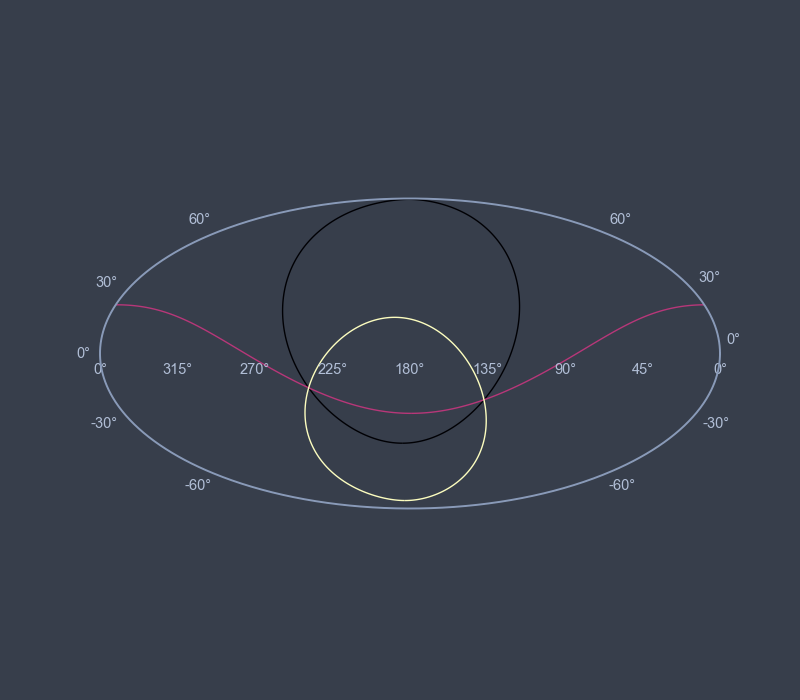

In [55]:
uni.plot_all_annuli(cmap='magma',lw=1);

<IPython.core.display.Javascript object>


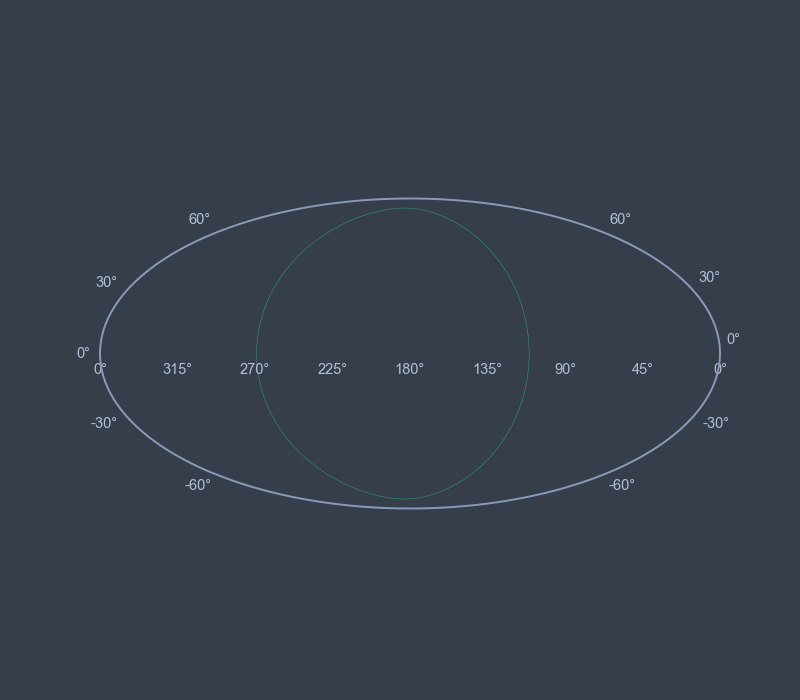

In [132]:
fig, ax = plt.subplots(subplot_kw=dict(projection='astro degrees mollweide'))


compute_annulus_from_time_delay(1.9, detector1=uni.detectors['det1'], detector2=uni.detectors['det2'], ax = ax )
    
   

In [55]:
n_verts = 3 * (3 - 1)/2
n_verts

3.0

<IPython.core.display.Javascript object>


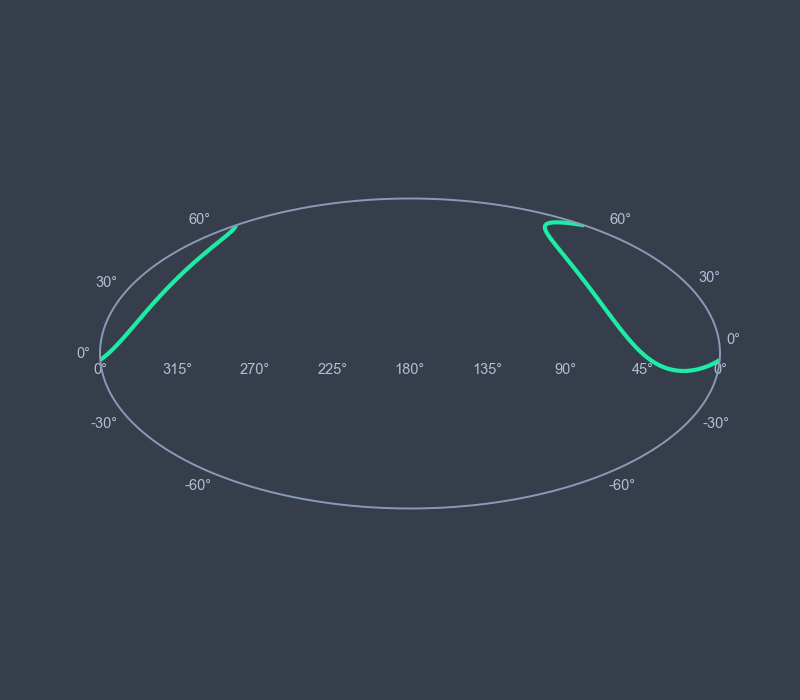

In [71]:
uni.plot_annulus('det1','det2',ec=green,fc='none',lw=3);

<IPython.core.display.Javascript object>


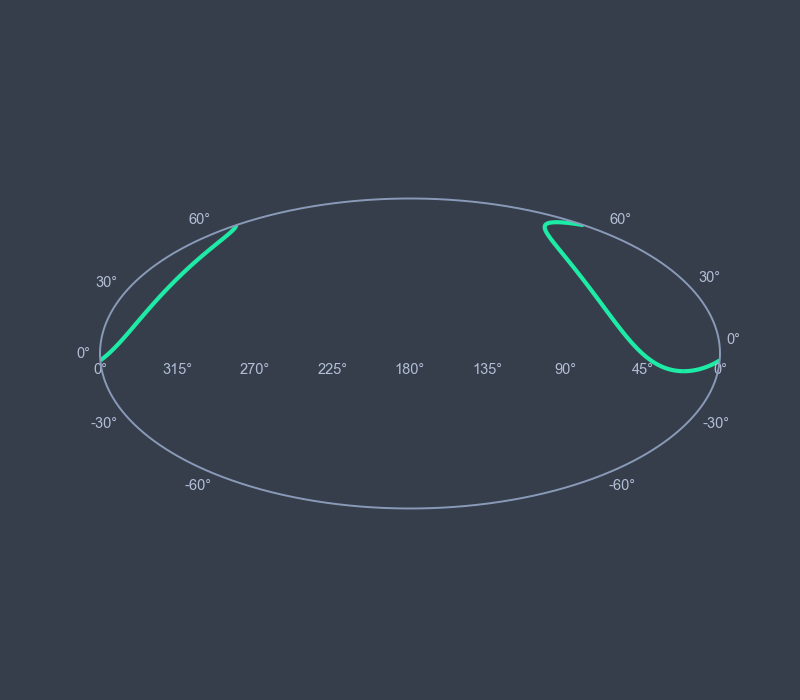

In [72]:
uni.plot_annulus('det1','det3',ec=green,fc='none',lw=3);

<IPython.core.display.Javascript object>


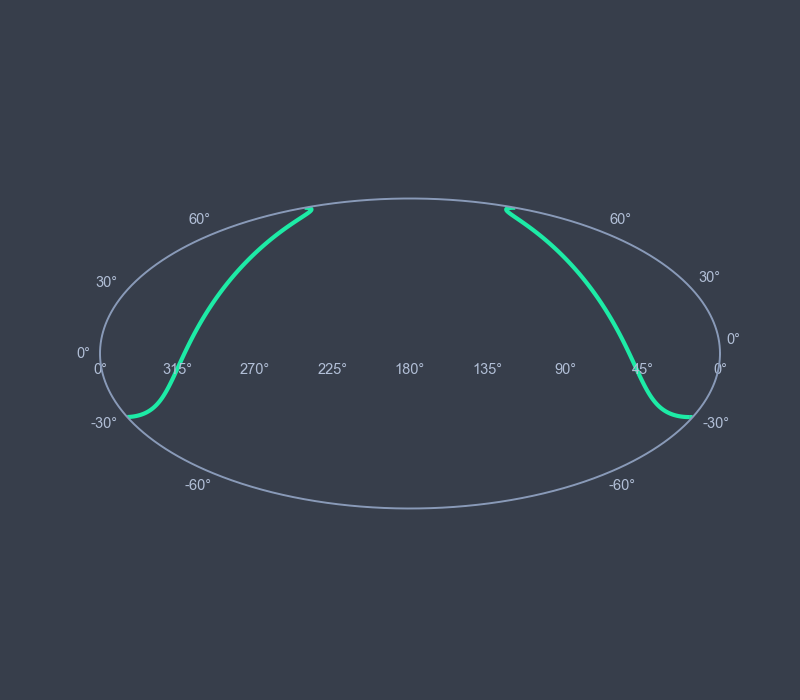

In [73]:
uni.plot_annulus('det2','det3',ec=green,fc='none',lw=3);

<IPython.core.display.Javascript object>


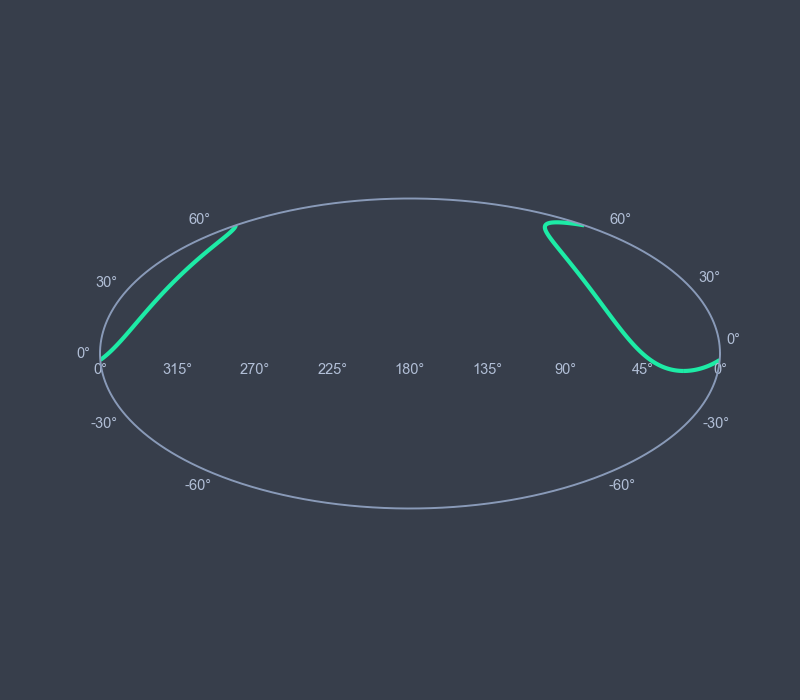

In [74]:
uni.plot_annulus('det2','det1',ec=green,fc='none',lw=3);

In [ ]:
def compute_annulus_from_time_delay(time_delay, detector1, detector2):
    
    dxyz = (  detector2.location.get_cartesian_coord().xyz - detector1.location.get_cartesian_coord().xyz)
            
    dcart = Location(
    SkyCoord(
        x=dxyz[0],
        y=dxyz[1],
        z=dxyz[2],
        representation_type="cartesian",
        unit="km",
     #   frame='icrs'
    )
        )
    
    
    norm_d = dcart.get_norm_vec(u.km)
    
    
    print(norm_d)
    
    distance = np.linalg.norm(dxyz) * u.km
    
    theta = np.arccos(
            np.around(((-const.c * time_delay*u.s ).to('km')/ distance).value, 15)
        )
    
    
    ra = dcart.coord.represent_as(UnitSphericalRepresentation).lon
    dec = dcart.coord.represent_as(UnitSphericalRepresentation).lat